# DQN

## Setup

### Initialization

In [1]:
import datetime
import logging
import shutil
from collections import deque, namedtuple, OrderedDict
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt

# import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
import ipdb

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# from torchinfo import summary

# if GPU is to be used
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [3]:
import plotting

# from environment_lights_tensor import (
#     WrappedEnvironment,
#     Actions,
#     CONTEXTS_LABELS,
#     OdorCues,
#     LightCues,
# )
from agent_tensor import EpsilonGreedy
from environment_tensor import (
    CONTEXTS_LABELS,
    Actions,
    Cues,
    WrappedEnvironment,
    TriangleState,
)
from utils import Params, make_deterministic, random_choice

In [4]:
# Formatting & autoreload stuff
%load_ext lab_black
%load_ext autoreload
%autoreload 2
# %matplotlib ipympl

In [5]:
sns.set_theme(font_scale=1.5)
# plt.style.use("ggplot")
print(shutil.which("latex"))
USETEX = True if shutil.which("latex") else False
mpl.rcParams["text.usetex"] = USETEX
if USETEX:
    mpl.rcParams["font.family"] = ["serif"]
else:
    mpl.rcParams["font.family"] = ["sans-serif"]
    mpl.rcParams["font.sans-serif"] = [
        "Fira Sans",
        "Computer Modern Sans Serif",
        "DejaVu Sans",
        "Verdana",
        "Arial",
        "Helvetica",
    ]

/home/kir0ul/texlive/2023/bin/x86_64-linux/latex


### Save directory

In [6]:
now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
now

'2024-04-12_16-43-14'

In [7]:
ROOT_PATH = Path("env").parent
SAVE_PATH = ROOT_PATH / "save"
CURRENT_PATH = SAVE_PATH / now
CURRENT_PATH.mkdir(parents=True, exist_ok=True)  # Create the tree of directories
print(f"Save path: `{CURRENT_PATH.absolute()}`")

Save path: `/home/kir0ul/Projects/RL_Olfaction/TriangleTask/save/2024-04-12_16-43-14`


In [8]:
# Configure logging
logfile = CURRENT_PATH / "training.log"
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
handler = logging.FileHandler(logfile)
formatter = logging.Formatter(
    "%(asctime)s : %(name)s  : %(funcName)s : %(levelname)s : %(message)s"
)
handler.setFormatter(formatter)
logger.addHandler(handler)

### Parameters

In [9]:
p = Params(
    # seed=42,
    # seed=123,
    n_runs=1,
    total_episodes=600,
    epsilon=0.5,
    alpha=1e-4,
    gamma=0.99,
    # nHiddenUnits=(5 * 5 + 3) * 5,
    nHiddenUnits=128,
    replay_buffer_max_size=5000,
    epsilon_min=0.2,
    epsilon_max=1.0,
    decay_rate=0.01,
    epsilon_warmup=100,
    batch_size=32,
    # target_net_update=200,
    tau=0.005,
)
p

Params(seed=None, n_runs=1, total_episodes=600, epsilon=0.5, epsilon_min=0.2, epsilon_max=1.0, decay_rate=0.01, epsilon_warmup=100, gamma=0.99, alpha=0.0001, nLayers=5, nHiddenUnits=128, n_observations=None, n_actions=None, replay_buffer_max_size=5000, batch_size=32, target_net_update=100, tau=0.005)

In [10]:
if p.batch_size < 2:
    raise ValueError("The batch size needs to be more that one data point")

In [11]:
# Set the seed
GENERATOR = make_deterministic(seed=p.seed)

### Environment definition

In [12]:
# Load the environment
env = WrappedEnvironment(one_hot_state=True, seed=p.seed)

In [13]:
# Get number of actions
# n_actions = env.action_space.n
p.n_actions = env.numActions

# Get the number of state observations
# state, info = env.reset()
state = env.reset()
p.n_observations = len(state)

print(f"Number of actions: {p.n_actions}")
print(f"Number of observations: {p.n_observations}")

Number of actions: 4
Number of observations: 28


### Network definition

In [14]:
ENCODER_NEURONS_NUM = 5


class DQN(nn.Module):
    def __init__(self, n_observations, n_actions, n_units=16):
        super(DQN, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(n_observations, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, ENCODER_NEURONS_NUM),
            nn.ReLU(),
            nn.Linear(ENCODER_NEURONS_NUM, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_actions),
            # nn.ReLU(),
        )

    def forward(self, x):
        return self.mlp(x)

In [15]:
def neural_network():
    # if env.one_hot_state:
    #     net = DQN(
    #         n_observations=p.n_observations,
    #         n_actions=p.n_actions,
    #         n_units=4 * p.n_observations,
    #     ).to(DEVICE)
    # else:
    #     net = DQN(
    #         n_observations=p.n_observations,
    #         n_actions=p.n_actions,
    #         n_units=p.nHiddenUnits,
    #     ).to(DEVICE)
    # net

    net = DQN(
        n_observations=p.n_observations,
        n_actions=p.n_actions,
        n_units=p.nHiddenUnits,
    ).to(DEVICE)

    target_net = DQN(
        n_observations=p.n_observations,
        n_actions=p.n_actions,
        n_units=p.nHiddenUnits,
    ).to(DEVICE)

    target_net.load_state_dict(net.state_dict())

    return net, target_net

In [16]:
net, target_net = neural_network()
net, target_net

(DQN(
   (mlp): Sequential(
     (0): Linear(in_features=28, out_features=128, bias=True)
     (1): ReLU()
     (2): Linear(in_features=128, out_features=128, bias=True)
     (3): ReLU()
     (4): Linear(in_features=128, out_features=5, bias=True)
     (5): ReLU()
     (6): Linear(in_features=5, out_features=128, bias=True)
     (7): ReLU()
     (8): Linear(in_features=128, out_features=128, bias=True)
     (9): ReLU()
     (10): Linear(in_features=128, out_features=4, bias=True)
   )
 ),
 DQN(
   (mlp): Sequential(
     (0): Linear(in_features=28, out_features=128, bias=True)
     (1): ReLU()
     (2): Linear(in_features=128, out_features=128, bias=True)
     (3): ReLU()
     (4): Linear(in_features=128, out_features=5, bias=True)
     (5): ReLU()
     (6): Linear(in_features=5, out_features=128, bias=True)
     (7): ReLU()
     (8): Linear(in_features=128, out_features=128, bias=True)
     (9): ReLU()
     (10): Linear(in_features=128, out_features=4, bias=True)
   )
 ))

In [17]:
weights_untrained = [layer.detach() for layer in net.parameters()]

In [18]:
# print("Model parameters:")
# print(list(net.parameters()))
print("\n\nParameters sizes summary:")
print([item.shape for item in net.parameters()])



Parameters sizes summary:
[torch.Size([128, 28]), torch.Size([128]), torch.Size([128, 128]), torch.Size([128]), torch.Size([5, 128]), torch.Size([5]), torch.Size([128, 5]), torch.Size([128]), torch.Size([128, 128]), torch.Size([128]), torch.Size([4, 128]), torch.Size([4])]


In [19]:
# summary(net, input_size=[state.shape], verbose=0)

### Optimizer

In [20]:
optimizer = optim.AdamW(net.parameters(), lr=p.alpha, amsgrad=True)
optimizer

AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
)

### Explorer

In [21]:
explorer = EpsilonGreedy(
    epsilon=p.epsilon_max,
    epsilon_min=p.epsilon_min,
    epsilon_max=p.epsilon_max,
    decay_rate=p.decay_rate,
    epsilon_warmup=p.epsilon_warmup,
    seed=p.seed,
)
episodes = torch.arange(p.total_episodes, device=DEVICE)
epsilons = torch.empty_like(episodes, device=DEVICE) * torch.nan
for eps_i, epsi in enumerate(epsilons):
    epsilons[eps_i] = explorer.epsilon
    explorer.epsilon = explorer.update_epsilon(episodes[eps_i])

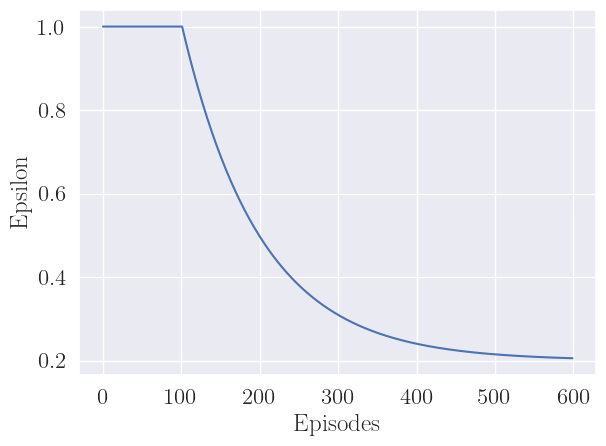

In [22]:
fig, ax = plt.subplots()
sns.lineplot(epsilons.cpu())
ax.set(ylabel="Epsilon")
ax.set(xlabel="Episodes")
fig.tight_layout()
plt.show()

In [23]:
def collect_weights_biases(net):
    biases = {"val": [], "grad": []}
    weights = {"val": [], "grad": []}
    for layer in net.mlp.children():
        layer_params = layer.parameters()
        for idx, subparams in enumerate(layer_params):
            if idx > 2:
                raise ValueError(
                    "There should be max 2 sets of parameters: weights and biases"
                )
            if len(subparams.shape) > 2:
                raise ValueError("The weights have more dimensions than expected")

            if len(subparams.shape) == 1:
                biases["val"].append(subparams)
                biases["grad"].append(subparams.grad)
            elif len(subparams.shape) == 2:
                weights["val"].append(subparams)
                weights["grad"].append(subparams.grad)
    return weights, biases

In [24]:
def params_df_stats(weights, key, current_df=None):
    if current_df is not None:
        last_idx = current_df.index[-1] + 1
        df = current_df
    else:
        last_idx = 0
        df = None

    for idx, val in enumerate(weights[key]):
        tmp_df = pd.DataFrame(
            data={
                "Std": val.detach().cpu().std().item(),
                "Avg": val.detach().cpu().mean().item(),
                "Layer": idx,
                "Index": [last_idx + idx],
            },
            index=[last_idx + idx],
        )

        if df is None:
            df = tmp_df
        else:
            df = pd.concat((df, tmp_df))
    return df

## Training

In [25]:
Transition = namedtuple(
    "Transition", ("state", "action", "reward", "next_state", "done")
)

### Main loop

In [26]:
rewards = torch.zeros((p.total_episodes, p.n_runs), device=DEVICE)
steps = torch.zeros((p.total_episodes, p.n_runs), device=DEVICE)
episodes = torch.arange(p.total_episodes, device=DEVICE)
# all_states = []
all_actions = []
losses = [[] for _ in range(p.n_runs)]

for run in range(p.n_runs):  # Run several times to account for stochasticity
    # Reset everything
    net, target_net = neural_network()  # Reset weights
    optimizer = optim.AdamW(net.parameters(), lr=p.alpha, amsgrad=True)
    explorer = EpsilonGreedy(
        epsilon=p.epsilon_max,
        epsilon_min=p.epsilon_min,
        epsilon_max=p.epsilon_max,
        decay_rate=p.decay_rate,
        epsilon_warmup=p.epsilon_warmup,
    )
    weights_val_stats = None
    biases_val_stats = None
    weights_grad_stats = None
    biases_grad_stats = None
    replay_buffer = deque([], maxlen=p.replay_buffer_max_size)
    epsilons = []

    for episode in tqdm(
        episodes, desc=f"Run {run+1}/{p.n_runs} - Episodes", leave=False
    ):
        state = env.reset()  # Reset the environment
        state = state.clone().float().detach().to(DEVICE)
        step_count = 0
        done = False
        total_rewards = 0
        loss = torch.ones(1, device=DEVICE) * torch.nan

        while not done:
            state_action_values = net(state).to(DEVICE)  # Q(s_t)
            action = explorer.choose_action(
                action_space=env.action_space,
                state=state,
                state_action_values=state_action_values,
            ).item()

            # Record states and actions
            # all_states.append(state)
            # all_actions.append(Actions(action.item()).name)
            all_actions.append(Actions(action).name)

            next_state, reward, done = env.step(action=action, current_state=state)

            # Store transition in replay buffer
            # [current_state (2 or 28 x1), action (1x1), next_state (2 or 28 x1), reward (1x1), done (1x1 bool)]
            done = torch.tensor(done, device=DEVICE).unsqueeze(-1)
            replay_buffer.append(
                Transition(
                    state,
                    action,
                    reward,
                    next_state,
                    done,
                )
            )

            # Start training when `replay_buffer` is full
            if len(replay_buffer) == p.replay_buffer_max_size:
                transitions = random_choice(
                    replay_buffer,
                    length=len(replay_buffer),
                    num_samples=p.batch_size,
                    generator=GENERATOR,
                )
                batch = Transition(*zip(*transitions, strict=True))
                state_batch = torch.stack(batch.state)
                action_batch = torch.tensor(batch.action, device=DEVICE)
                reward_batch = torch.cat(batch.reward)
                next_state_batch = torch.stack(batch.next_state)
                done_batch = torch.cat(batch.done)

                # See DQN paper for equations: https://doi.org/10.1038/nature14236
                state_action_values_sampled = net(state_batch).to(DEVICE)  # Q(s_t)
                state_action_values = torch.gather(
                    input=state_action_values_sampled,
                    dim=1,
                    index=action_batch.unsqueeze(-1),
                ).squeeze()  # Q(s_t, a)

                # done_false = torch.argwhere(done_batch == False).squeeze()
                # done_true = torch.argwhere(done_batch == True).squeeze()
                # expected_state_action_values = (
                #     torch.zeros_like(done_batch, device=DEVICE)
                # ).float()
                # with torch.no_grad():
                #     if done_true.numel() > 0:
                #         expected_state_action_values[done_true] = reward_batch[
                #             done_true
                #         ]
                #     if done_false.numel() > 0:
                #         next_state_values = (
                #             target_net(next_state_batch[done_false]).to(DEVICE).max(1)
                #         )  # Q(s_t+1, a)
                #         expected_state_action_values[done_false] = (
                #             reward_batch[done_false]
                #             + p.gamma * next_state_values.values
                #         )  # y_j (Bellman optimality equation)

                # Compute a mask of non-final states and concatenate the batch elements
                # (a final state would've been the one after which simulation ended)
                non_final_mask = torch.tensor(
                    tuple(map(lambda s: s == False, batch.done)),
                    device=DEVICE,
                    dtype=torch.bool,
                )
                non_final_next_states = torch.stack(
                    [s[1] for s in zip(batch.done, batch.next_state) if s[0] == False]
                )

                # Compute V(s_{t+1}) for all next states.
                # Expected values of actions for non_final_next_states are computed based
                # on the "older" target_net; selecting their best reward with max(1).values
                # This is merged based on the mask, such that we'll have either the expected
                # state value or 0 in case the state was final.
                next_state_values = torch.zeros(p.batch_size, device=DEVICE)
                if non_final_next_states.numel() > 0 and non_final_mask.numel() > 0:
                    with torch.no_grad():
                        next_state_values[non_final_mask] = (
                            target_net(non_final_next_states).max(1).values
                        )
                # Compute the expected Q values
                expected_state_action_values = reward_batch + (
                    next_state_values * p.gamma
                )

                # Compute loss
                # criterion = nn.MSELoss()
                criterion = nn.SmoothL1Loss()
                loss = criterion(
                    input=state_action_values,  # prediction
                    target=expected_state_action_values,  # target/"truth" value
                )  # TD update

                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_value_(
                    net.parameters(), 100
                )  # In-place gradient clipping
                optimizer.step()

                # # Reset the target network
                # if step_count % p.target_net_update == 0:
                #     target_net.load_state_dict(net.state_dict())

                # Soft update of the target network's weights
                # θ′ ← τ θ + (1 −τ )θ′
                target_net_state_dict = target_net.state_dict()
                net_state_dict = net.state_dict()
                for key in net_state_dict:
                    target_net_state_dict[key] = net_state_dict[
                        key
                    ] * p.tau + target_net_state_dict[key] * (1 - p.tau)
                target_net.load_state_dict(target_net_state_dict)

                losses[run].append(loss.item())

                weights, biases = collect_weights_biases(net=net)
                weights_val_stats = params_df_stats(
                    weights, key="val", current_df=weights_grad_stats
                )
                biases_val_stats = params_df_stats(
                    biases, key="val", current_df=biases_val_stats
                )
                biases_grad_stats = params_df_stats(
                    biases, key="grad", current_df=biases_grad_stats
                )
                weights_grad_stats = params_df_stats(
                    weights, key="grad", current_df=weights_val_stats
                )

            total_rewards += reward
            step_count += 1

            # Move to the next state
            state = next_state

            explorer.epsilon = explorer.update_epsilon(episode)
            epsilons.append(explorer.epsilon)

        rewards[episode, run] = total_rewards
        steps[episode, run] = step_count
        logger.info(
            f"Run: {run+1}/{p.n_runs} - Episode: {episode+1}/{p.total_episodes} - Steps: {step_count} - Loss: {loss.item()}"
        )
    weights_val_stats.set_index("Index", inplace=True)
    biases_val_stats.set_index("Index", inplace=True)
    biases_grad_stats.set_index("Index", inplace=True)
    weights_grad_stats.set_index("Index", inplace=True)

### Save data to disk

In [27]:
data_path = CURRENT_PATH / "data.npz"
with open(data_path, "wb") as f:
    np.savez(
        f,
        rewards=rewards.cpu(),
        steps=steps.cpu(),
        episodes=episodes.cpu(),
        all_actions=all_actions,
        # losses=losses,
        p=p,
    )

## Visualization

### Load data from disk

In [28]:
# with open(data_path, "rb") as f:
#     # Load the arrays from the .npz file
#     data = np.load(f, allow_pickle=True)

#     # Access individual arrays by their names
#     rewards = data["rewards"]
#     steps = data["steps"]
#     episodes = data["episodes"]
#     all_actions = data["all_actions"]
#     losses = data["losses"]
#     p = data["p"][()]

### Exploration rate

In [29]:
def plot_exploration_rate(epsilons, figpath=None):
    fig, ax = plt.subplots()
    sns.lineplot(epsilons)
    ax.set(ylabel="Epsilon")
    ax.set(xlabel="Steps")
    fig.tight_layout()
    fig.patch.set_alpha(0)
    fig.patch.set_facecolor("white")
    if figpath:
        fig.savefig(figpath / "exploration-rate.png", bbox_inches="tight")
    plt.show()

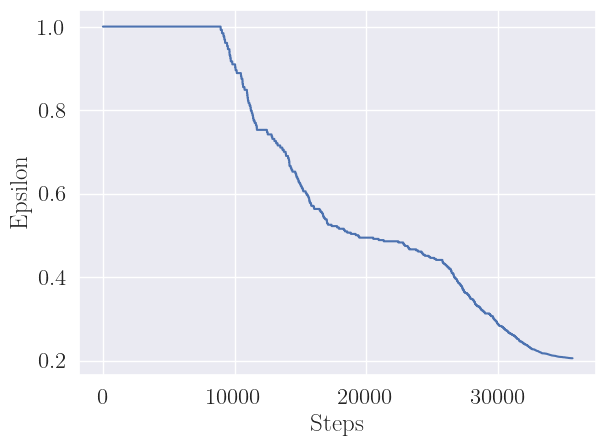

In [30]:
plot_exploration_rate(epsilons, figpath=CURRENT_PATH)

### States & actions distributions

In [31]:
def postprocess(episodes, p, rewards, steps):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": episodes.tile(p.n_runs).cpu(),
            "Rewards": rewards.T.flatten().cpu(),
            "Steps": steps.T.flatten().cpu(),
        }
    )
    # res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    return res

In [32]:
res = postprocess(episodes, p, rewards, steps)
res

,Episodes,Rewards,Steps
0,0,1.0,368.0
1,1,1.0,122.0
2,2,0.0,168.0
3,3,1.0,72.0
4,4,0.0,193.0
...,...,...,...
595,595,1.0,5.0
596,596,1.0,8.0
597,597,1.0,37.0
598,598,1.0,84.0


As a sanity check, we will plot the distributions of states and actions
with the following function:

In [33]:
def plot_actions_distribution(actions, figpath=None):
    """Plot the distributions of states and actions."""
    fig, ax = plt.subplots()
    sns.histplot(data=actions, ax=ax)
    ax.set_xticks(
        [item.value for item in Actions], labels=[item.name for item in Actions]
    )
    ax.set_title("Actions")
    fig.tight_layout()
    fig.patch.set_alpha(0)
    fig.patch.set_facecolor("white")
    if figpath:
        fig.savefig(figpath / "actions-distribution.png", bbox_inches="tight")
    plt.show()

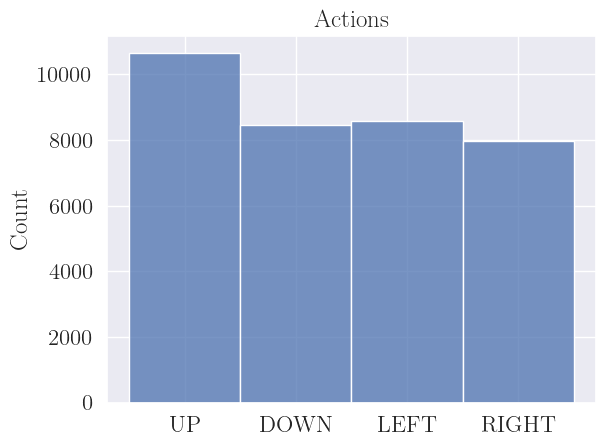

In [34]:
plot_actions_distribution(all_actions, figpath=CURRENT_PATH)

### Steps & rewards

In [35]:
def plot_steps_and_rewards(df, figpath=None):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(data=df, x="Episodes", y="Rewards", ax=ax[0])
    ax[0].set(
        ylabel=f"Rewards\naveraged over {p.n_runs} runs" if p.n_runs > 1 else "Rewards"
    )

    sns.lineplot(data=df, x="Episodes", y="Steps", ax=ax[1])
    ax[1].set(
        ylabel=(
            f"Steps number\naveraged over {p.n_runs} runs"
            if p.n_runs > 1
            else "Steps number"
        )
    )

    fig.tight_layout()
    fig.patch.set_alpha(0)
    fig.patch.set_facecolor("white")
    if figpath:
        fig.savefig(figpath / "steps-and-rewards.png", bbox_inches="tight")
    plt.show()

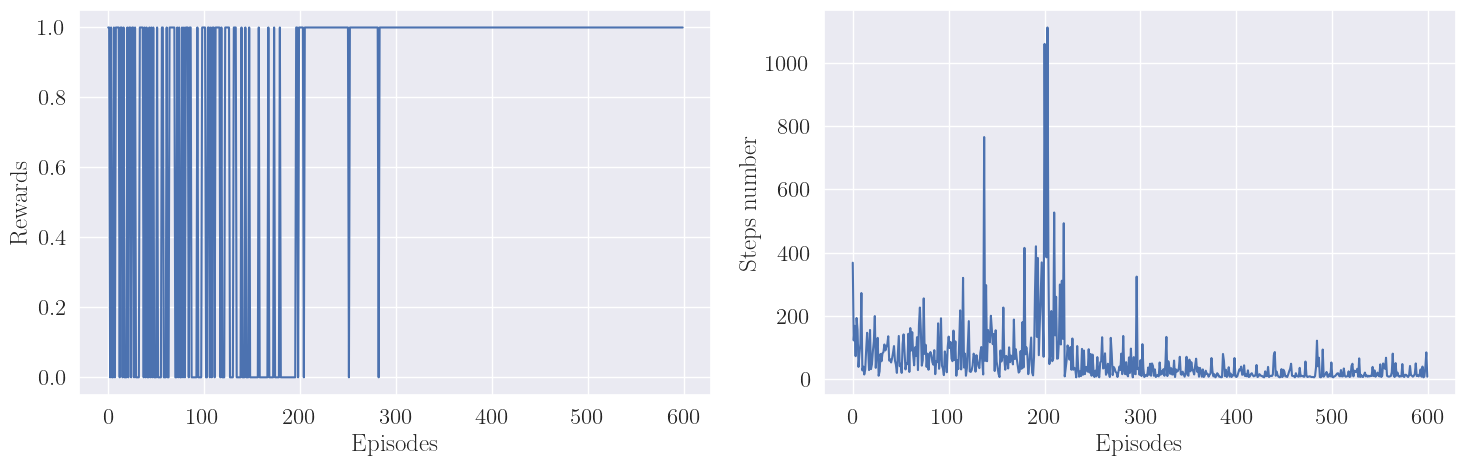

In [36]:
plot_steps_and_rewards(res, figpath=CURRENT_PATH)

In [37]:
def plot_steps_and_rewards_dist(df, figpath=None):
    """Plot the steps and rewards distributions from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=df, x="Rewards", ax=ax[0])
    sns.histplot(data=df, x="Steps", ax=ax[1])
    fig.tight_layout()
    fig.patch.set_alpha(0)
    fig.patch.set_facecolor("white")
    if figpath:
        fig.savefig(
            figpath / "steps-and-rewards-distrib.png",
            bbox_inches="tight",
        )
    plt.show()

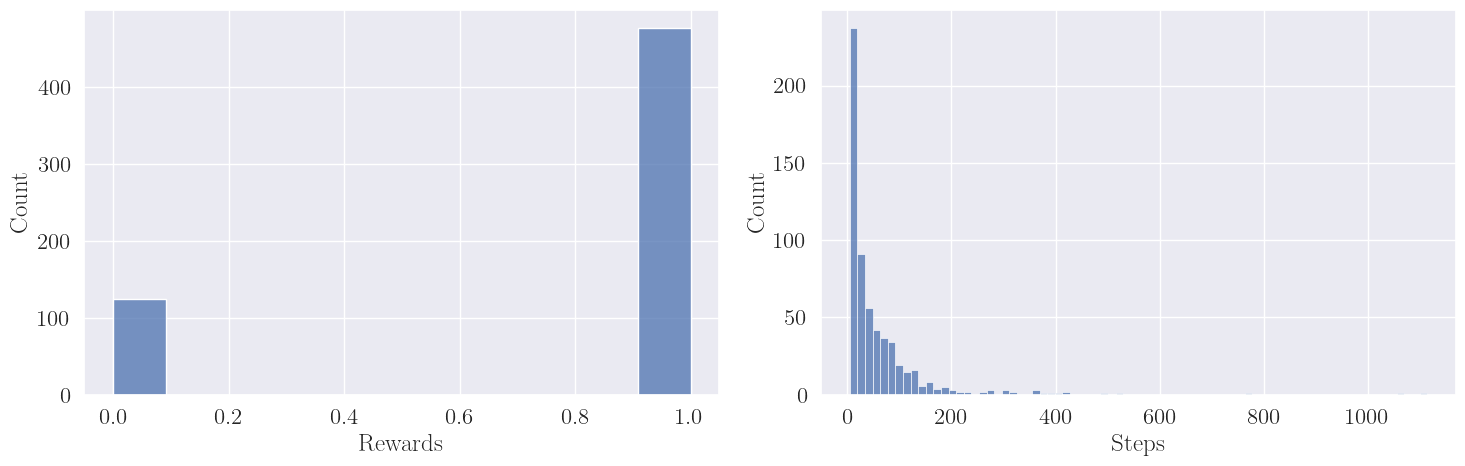

In [38]:
plot_steps_and_rewards_dist(res, figpath=CURRENT_PATH)

### Loss

In [39]:
window_size = 1
for idx, loss in enumerate(losses):
    current_loss = torch.tensor(loss, device=DEVICE)
    losses_rolling_avg = nn.functional.avg_pool1d(
        current_loss.view(1, 1, -1), kernel_size=window_size
    ).squeeze()
    tmp_df = pd.DataFrame(
        data={
            "Run": idx * torch.ones(len(losses_rolling_avg), device=DEVICE).int().cpu(),
            "Steps": torch.arange(0, len(losses_rolling_avg), device=DEVICE).cpu(),
            "Loss": losses_rolling_avg.cpu(),
        }
    )
    if idx == 0:
        loss_df = tmp_df
    else:
        loss_df = pd.concat((loss_df, tmp_df))
loss_df

,Run,Steps,Loss
0,0,0,0.002582
1,0,1,0.001440
2,0,2,0.002628
3,0,3,0.015685
4,0,4,0.029862
...,...,...,...
30654,0,30654,0.000131
30655,0,30655,0.000246
30656,0,30656,0.000616
30657,0,30657,0.000087


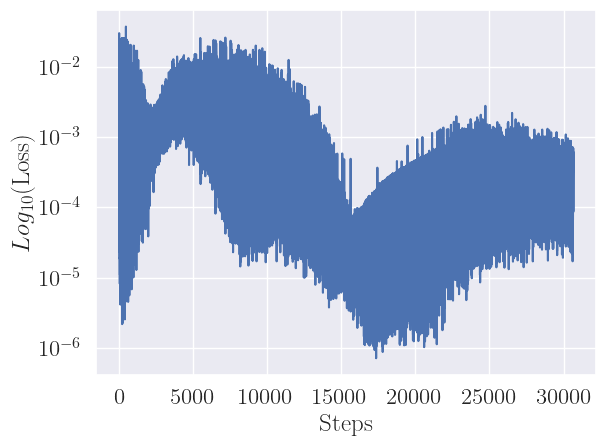

In [40]:
fig, ax = plt.subplots()
sns.lineplot(data=loss_df, x="Steps", y="Loss", ax=ax)
if USETEX:
    ax.set(
        ylabel=(
            f"$Log_{{10}}(\mathrm{{Loss}})$\naveraged over {p.n_runs} runs"
            if p.n_runs > 1
            else "$Log_{10}(\mathrm{Loss})$"
        )
    )
else:
    ax.set(
        ylabel=(
            f"$Log_{{10}}(\\text{{Loss}})$\naveraged over {p.n_runs} runs"
            if p.n_runs > 1
            else "$Log_{10}(\\text{Loss})$"
        )
    )
ax.set(xlabel="Steps")
ax.set(yscale="log")
fig.tight_layout()
fig.patch.set_alpha(0)
fig.patch.set_facecolor("white")
fig.savefig(CURRENT_PATH / "loss.png", bbox_inches="tight")
plt.show()

### Policy learned

In [41]:
with torch.no_grad():
    q_values = torch.nan * torch.empty(
        (len(env.tiles_locations), len(Cues), p.n_actions), device=DEVICE
    )
    for tile_i, tile_v in enumerate(env.tiles_locations):
        for cue_i, cue_v in enumerate(Cues):
            state = torch.tensor([tile_v, cue_v.value], device=DEVICE).float()
            if env.one_hot_state:
                state = env.to_one_hot(state).float()
            q_values[tile_i, cue_i, :] = net(state).to(DEVICE)
q_values.shape

torch.Size([25, 3, 4])

In [42]:
# with torch.no_grad():
#     q_values = torch.nan * torch.empty(
#         (len(env.tiles_locations), len(OdorCues), len(LightCues), p.n_actions),
#         device=DEVICE,
#     )
#     for tile_i, tile_v in enumerate(env.tiles_locations):
#         for o_cue_i, o_cue_v in enumerate(OdorCues):
#             for l_cue_i, l_cue_v in enumerate(LightCues):
#                 state = torch.tensor(
#                     [tile_v, o_cue_v.value, l_cue_v.value], device=DEVICE
#                 ).float()
#                 if env.one_hot_state:
#                     state = env.to_one_hot(state).float()
#                 q_values[tile_i, cue_i, :] = net(state).to(DEVICE)
# q_values.shape

In [43]:
def qtable_directions_map(qtable, rows, cols):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).values.reshape(rows, cols)
    qtable_best_action = qtable.argmax(axis=1).reshape(rows, cols)
    directions = {
        Actions.UP: "↑",
        Actions.DOWN: "↓",
        Actions.LEFT: "←",
        Actions.RIGHT: "→",
    }
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = torch.finfo(torch.float64).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[Actions(val.item())]
    qtable_directions = qtable_directions.reshape(rows, cols)
    return qtable_val_max, qtable_directions

In [44]:
def plot_policies(q_values, labels, figpath=None):
    """
    Plot the heatmap of the Q-values.

    Also plot the best action's direction with arrows.
    """
    fig, ax = plt.subplots(2, len(labels), figsize=(13, 8))
    for tri_i, tri_v in enumerate(TriangleState):
        for cue_i, cue_v in enumerate(labels):
            qtable_val_max, qtable_directions = qtable_directions_map(
                qtable=q_values[:, cue_i, :], rows=env.rows, cols=env.cols
            )
            if tri_v == TriangleState.upper:
                qtable_val_max = torch.triu(qtable_val_max)
                qtable_directions = np.triu(qtable_directions)
            elif tri_v == TriangleState.lower:
                qtable_val_max = torch.tril(qtable_val_max)
                qtable_directions = np.tril(qtable_directions)
            sns.heatmap(
                qtable_val_max.cpu(),
                annot=qtable_directions,
                fmt="",
                ax=ax[tri_i, cue_i],
                cmap=sns.color_palette("Blues", as_cmap=True),
                linewidths=0.7,
                linecolor="black",
                xticklabels=[],
                yticklabels=[],
                annot_kws={"fontsize": "xx-large"},
                cbar_kws={"label": "Q-value"},
            ).set(title=labels[cue_v])
            for _, spine in ax[tri_i, cue_i].spines.items():
                spine.set_visible(True)
                spine.set_linewidth(0.7)
                spine.set_color("black")

            # Annotate the ports names
            bbox = {
                "facecolor": "black",
                "edgecolor": "none",
                "boxstyle": "round",
                "alpha": 0.1,
            }
            ax[tri_i, cue_i].text(
                x=4.7,
                y=0.3,
                s="N",
                bbox=bbox,
                color="white",
            )
            ax[tri_i, cue_i].text(
                x=0.05,
                y=4.9,
                s="S",
                bbox=bbox,
                color="white",
            )
            ax[tri_i, cue_i].text(
                x=4.7,
                y=4.9,
                s="E",
                bbox=bbox,
                color="white",
            )
            ax[tri_i, cue_i].text(
                x=0.05,
                y=0.3,
                s="W",
                bbox=bbox,
                color="white",
            )

    # Make background transparent
    fig.patch.set_alpha(0)
    fig.patch.set_facecolor("white")
    fig.tight_layout()
    if figpath:
        fig.savefig(figpath / "policy.png", bbox_inches="tight")
    plt.show()

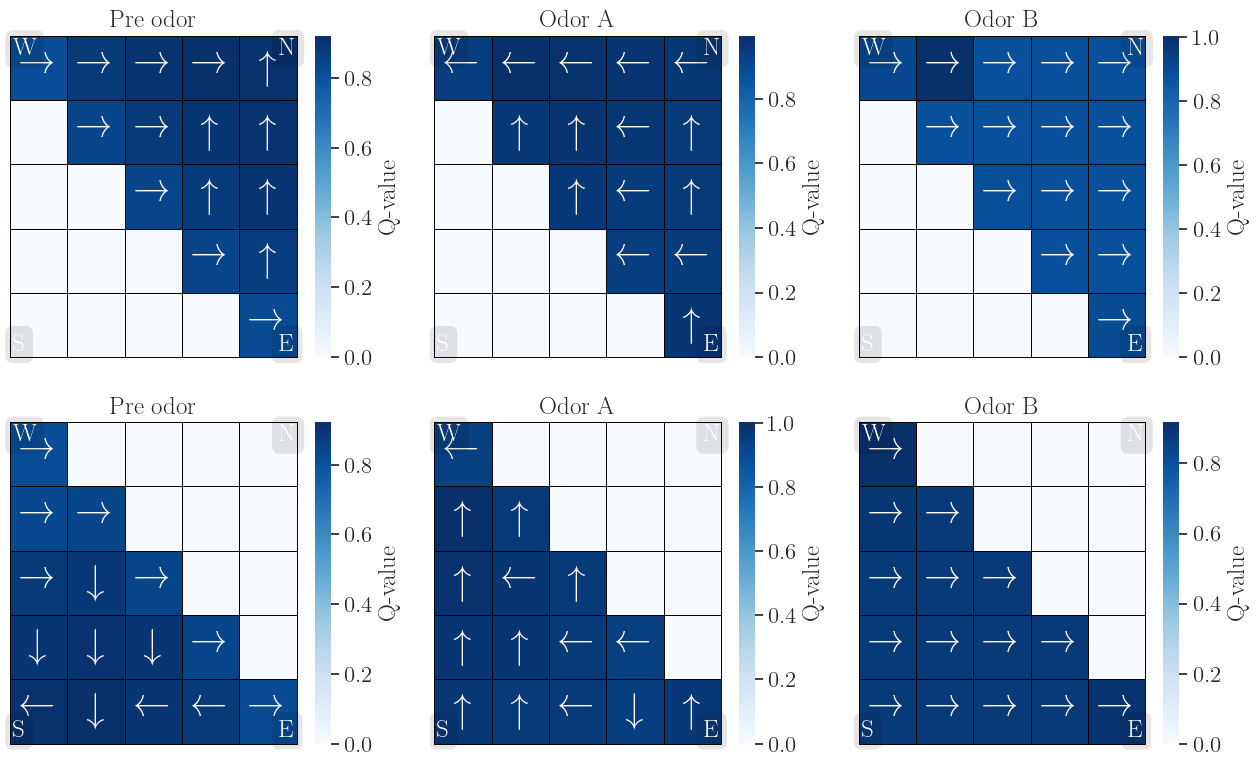

In [45]:
plot_policies(q_values=q_values, labels=CONTEXTS_LABELS, figpath=CURRENT_PATH)

### Weights matrix

In [46]:
def plot_weights_matrices(weights_untrained, weights_trained, figpath=None):
    fig = plt.figure(layout="constrained", figsize=(12, 17))
    subfigs = fig.subfigures(nrows=1, ncols=2)
    ax = []
    for subf in subfigs:
        ax.append(
            subf.subplots(
                nrows=round(len(weights_trained) / 2),
                ncols=2,
                width_ratios=[10, 1],
            )
        )
    subfigs[0].suptitle("Before training")
    subfigs[1].suptitle("After training")
    # subfigs[0].colorbar(pc, shrink=0.6, ax=axsLeft, location='bottom')
    # subfigs[1].colorbar(pc, shrink=0.6, ax=axsRight)
    # fig.suptitle('Weights')

    for idx, (w_untrained, w_trained) in enumerate(
        zip(weights_untrained, weights_trained)
    ):
        # cmap = "bwr"
        cmap = "coolwarm"

        plot_row = int(np.floor(idx / 2))  # Row index to lay out the plots

        if len(w_trained.shape) < 2:  # Biases
            b_untrained_current = w_untrained.unsqueeze(-1).detach().numpy()
            b_trained_current = w_trained.unsqueeze(-1).detach().numpy()
            sns.heatmap(b_untrained_current, ax=ax[0][plot_row, 1], cmap=cmap)
            sns.heatmap(b_trained_current, ax=ax[1][plot_row, 1], cmap=cmap)
            for axi in ax:
                axi[plot_row, 1].xaxis.set_major_locator(mpl.ticker.NullLocator())

        else:  # Weights
            w_untrained_current = w_untrained.detach().numpy()
            w_trained_current = w_trained.detach().numpy()
            sns.heatmap(w_untrained_current, ax=ax[0][plot_row, 0], cmap=cmap)
            sns.heatmap(w_trained_current, ax=ax[1][plot_row, 0], cmap=cmap)
            for axi in ax:
                axi[plot_row, 0].tick_params(labelbottom=False, labeltop=True)
                axi[plot_row, 0].xaxis.set_major_locator(
                    mpl.ticker.LinearLocator(numticks=3)
                )
                for axj in axi.flatten():
                    axj.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%d"))

    for axlr in ax:
        for axi in axlr:
            for axj in axi:
                axj.yaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=3))
                axj.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%d"))

        # fig.tight_layout()
        fig.patch.set_alpha(0)
        fig.patch.set_facecolor("white")
    if figpath:
        fig.savefig(figpath / "weights-matrices.png", bbox_inches="tight")
    plt.show()

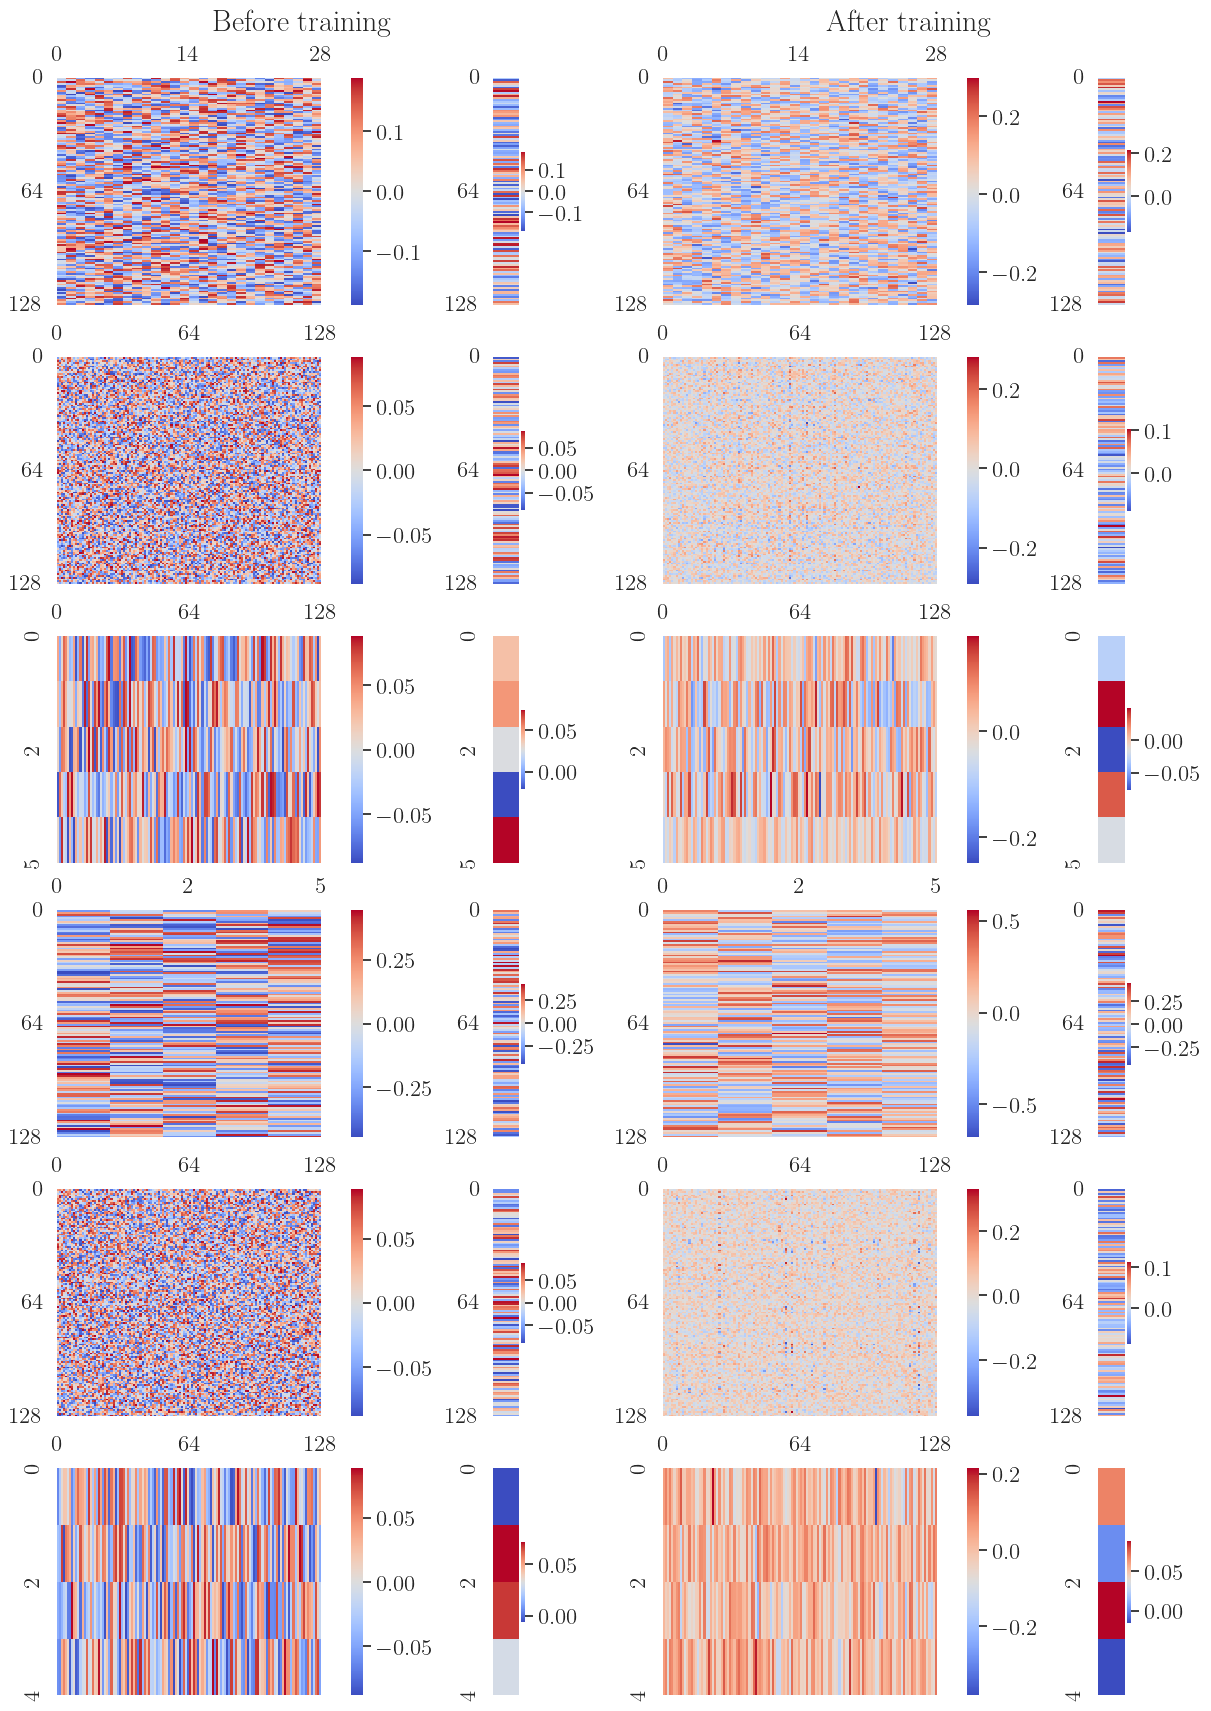

In [47]:
plot_weights_matrices(
    weights_untrained=weights_untrained,
    weights_trained=[layer for layer in net.parameters()],
    figpath=CURRENT_PATH,
)

### Activations learned

In [48]:
[item for item in net.mlp.named_children()]

[('0', Linear(in_features=28, out_features=128, bias=True)),
 ('1', ReLU()),
 ('2', Linear(in_features=128, out_features=128, bias=True)),
 ('3', ReLU()),
 ('4', Linear(in_features=128, out_features=5, bias=True)),
 ('5', ReLU()),
 ('6', Linear(in_features=5, out_features=128, bias=True)),
 ('7', ReLU()),
 ('8', Linear(in_features=128, out_features=128, bias=True)),
 ('9', ReLU()),
 ('10', Linear(in_features=128, out_features=4, bias=True))]

In [49]:
# Hook to capture the activations
activations = {}


def get_activation(name):
    def hook(module, args, output):
        activations[name] = output.detach()

    return hook

In [50]:
# Register the hooks for all layers
for name, layer in net.mlp.named_children():
    layer.register_forward_hook(get_activation(name))

In [51]:
x = torch.randn(28)
output = net(x)

In [52]:
[val.shape for key, val in activations.items()]

[torch.Size([128]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([5]),
 torch.Size([5]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([4])]

In [53]:
# Construct input dictionnary to be fed to the network
input_cond = OrderedDict({})
for cue_obj, cue_txt in CONTEXTS_LABELS.items():
    for loc in env.state_space["location"]:
        current_state = torch.tensor([loc, cue_obj.value], device=DEVICE)
        if env.one_hot_state:
            current_state = env.to_one_hot(current_state)
        input_cond[f"{loc}-{cue_txt}"] = current_state.float()

In [54]:
# Get the activations from the network
layer_inspected = 6 - 1
activations_layer = (
    torch.ones((len(input_cond), ENCODER_NEURONS_NUM), device=DEVICE) * torch.nan
)
for idx, (cond, input_val) in enumerate(input_cond.items()):
    net(input_val)
    activations_layer[idx, :] = activations[str(layer_inspected)]

In [55]:
# cols = pd.MultiIndex.from_tuples(
#     [("neuron", str(item)) for item in range(1, ENCODER_NEURONS_NUM + 1)]
# )
activations_layer_df = pd.DataFrame(activations_layer)  # , columns=cols)
activations_layer_df["Input"] = list(input_cond.keys())
activations_layer_df.set_index("Input", inplace=True)
activations_layer_df

,0,1,2,3,4
Input,,,,,
0-Pre odor,0.012239,0.320759,0.043361,0.401510,0.0
1-Pre odor,0.053089,0.232771,0.000000,0.220816,0.0
2-Pre odor,0.046120,0.145285,0.000000,0.097316,0.0
3-Pre odor,0.033059,0.100821,0.000000,0.000000,0.0
4-Pre odor,0.088845,0.000000,0.000000,0.134495,0.0
...,...,...,...,...,...
20-Odor B,0.000000,0.000000,0.000000,0.000000,0.0
21-Odor B,0.000000,0.000000,0.000000,0.000000,0.0
22-Odor B,0.000000,0.000000,0.000000,0.000000,0.0


In [56]:
# def plot_activations(activations_layer, figpath=None):
#     fig, ax = plt.subplots(figsize=(10, 15))
#     sns.heatmap(activations_layer, ax=ax)
#     ax.set(xlabel=f"Neurons activations in layer {layer_inspected + 1}")
#     ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
#     ax.xaxis.set_label_position("top")
#     ax.set_yticks(np.arange(len(input_cond)) + 0.5)
#     ax.set_yticklabels(list(input_cond.keys()), rotation=0)
#     fig.tight_layout()
#     fig.patch.set_alpha(0)
#     fig.patch.set_facecolor("white")
#     if figpath:
#         fig.savefig(figpath / "activations-learned.png", bbox_inches="tight")
#     plt.show()

In [57]:
# plot_activations(activations_layer, figpath=CURRENT_PATH)

In [102]:
def plot_activations(activations_layer, input_cond, labels, figpath=None):
    # Create a categorical palette to identify the clusters
    # cluster_palette = sns.color_palette("Pastel2")
    cluster_palette = sns.color_palette("Accent")
    cluster_colors = dict(zip(list(labels.values()), cluster_palette))
    row_colors = [cluster_colors[cond.split("-")[1]] for cond in input_cond.keys()]
    row_colors_serie = pd.Series(row_colors)
    row_colors_serie = row_colors_serie.set_axis(list(input_cond.keys()))

    # cmap = "mako"
    # cmap = "rocket"
    # cmap = "magma"
    cmap = "viridis"
    chart = sns.clustermap(activations_layer_df, cmap=cmap, row_colors=row_colors_serie)
    chart.ax_heatmap.set_xlabel(f"Neurons activations in layer {layer_inspected + 1}")

    for label, col_val in cluster_colors.items():
        chart.ax_col_dendrogram.bar(0, 0, color=col_val, label=label, linewidth=0)
    chart.ax_col_dendrogram.legend(loc="center", bbox_to_anchor=(1.1, 0.7))  # , ncol=6)

    chart.fig.patch.set_alpha(0)
    chart.fig.patch.set_facecolor("white")
    if figpath:
        chart.savefig(figpath / "activations-learned.png", bbox_inches="tight")
    plt.show()

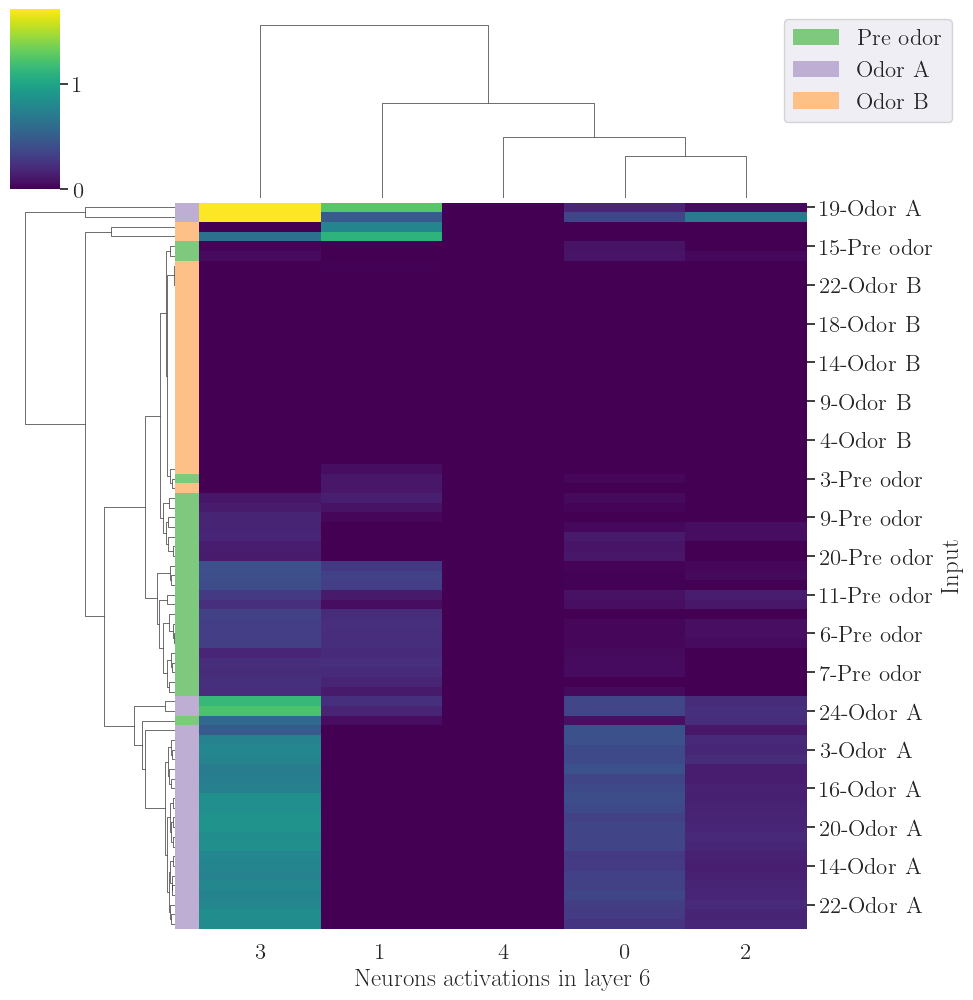

In [103]:
plot_activations(
    activations_layer=activations_layer,
    input_cond=input_cond,
    labels=CONTEXTS_LABELS,
    figpath=CURRENT_PATH,
)

### Weights & gradients metrics

In [60]:
weights, biases = collect_weights_biases(net=net)

In [61]:
def params_df_flat(weights):
    for idx, val in enumerate(weights):
        tmp_df = pd.DataFrame(
            data={
                "Val": val.detach().cpu().flatten(),
                "Layer": idx,
            }
        )
        if idx == 0:
            df = tmp_df
        else:
            df = pd.concat((df, tmp_df))
    return df

In [62]:
weights_val_df = params_df_flat(weights["val"])
weights_val_df

,Val,Layer
0,0.092003,0
1,-0.070039,0
2,-0.107162,0
3,-0.141374,0
4,-0.119311,0
...,...,...
507,-0.046874,5
508,0.002326,5
509,-0.049108,5
510,-0.067058,5


In [63]:
weights_val_df.describe()

,Val,Layer
count,38144.000000,38144.000000
mean,0.002871,2.298658
std,0.075813,1.603728
min,-0.680198,0.000000
25%,-0.046866,1.000000
50%,0.003239,1.000000
75%,0.052746,4.000000
max,0.557904,5.000000


In [64]:
biases_val_df = params_df_flat(biases["val"])
biases_val_df

,Val,Layer
0,-0.024585,0
1,0.161697,0
2,0.126807,0
3,0.174012,0
4,0.058574,0
...,...,...
127,0.053733,4
0,0.068177,5
1,0.000485,5
2,0.088875,5


In [65]:
biases_val_df.describe()

,Val,Layer
count,521.000000,521.000000
mean,0.005360,2.023033
std,0.140114,1.590672
min,-0.441880,0.000000
25%,-0.055245,1.000000
50%,0.002040,2.000000
75%,0.066956,4.000000
max,0.451002,5.000000


In [66]:
weights_grad_df = params_df_flat(weights["grad"])
weights_grad_df

,Val,Layer
0,0.000000,0
1,0.000000,0
2,0.000000,0
3,0.000000,0
4,0.000000,0
...,...,...
507,0.000000,5
508,-0.000003,5
509,0.000000,5
510,0.000000,5


In [67]:
weights_grad_df.describe()

,Val,Layer
count,3.814400e+04,38144.000000
mean,2.326338e-06,2.298658
std,5.661108e-05,1.603728
min,-1.449430e-03,0.000000
25%,-3.683992e-10,1.000000
50%,0.000000e+00,1.000000
75%,3.327945e-08,4.000000
max,2.291872e-03,5.000000


In [68]:
biases_grad_df = params_df_flat(biases["grad"])
biases_grad_df

,Val,Layer
0,1.833435e-06,0
1,8.891174e-06,0
2,-4.390947e-07,0
3,-2.992827e-06,0
4,-1.279087e-05,0
...,...,...
127,2.400674e-04,4
0,7.177573e-04,5
1,-1.938544e-03,5
2,-4.348010e-04,5


In [69]:
biases_grad_df.describe()

,Val,Layer
count,521.000000,521.000000
mean,0.000017,2.023033
std,0.000210,1.590672
min,-0.001939,0.000000
25%,-0.000012,1.000000
50%,0.000000,2.000000
75%,0.000024,4.000000
max,0.003101,5.000000


In [70]:
def check_grad_stats(grad_df):
    grad_stats = torch.tensor(
        [
            grad_df.Val.mean(),
            grad_df.Val.std(),
            grad_df.Val.min(),
            grad_df.Val.max(),
        ],
        device=DEVICE,
    )
    assert not torch.equal(
        torch.zeros_like(grad_stats, device=DEVICE),
        grad_stats,
    ), "Gradients are zero"

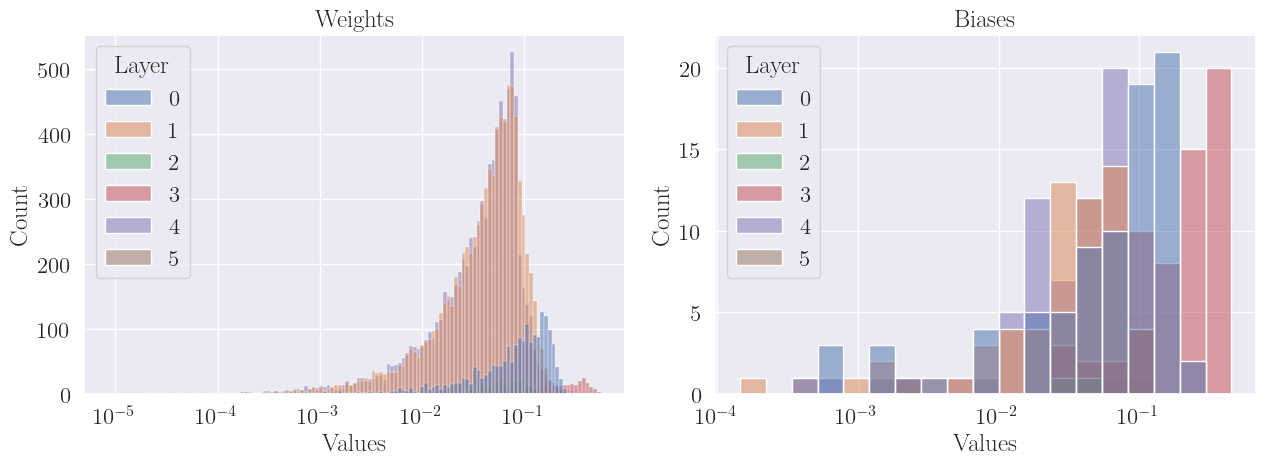

In [71]:
plotting.plot_weights_biases_distributions(
    weights_val_df, biases_val_df, label="Values", figpath=CURRENT_PATH
)

In [72]:
check_grad_stats(weights_grad_df)

In [73]:
check_grad_stats(biases_grad_df)

In [74]:
plotting.plot_weights_biases_distributions(
    weights_grad_df, biases_grad_df, label="Gradients", figpath=CURRENT_PATH
)

IndexError: index out of range

Error in callback <function _draw_all_if_interactive at 0x7f21a00c31a0> (for post_execute):


IndexError: index out of range

IndexError: index out of range

<Figure size 1300x500 with 2 Axes>

In [ ]:
weights_val_stats

In [ ]:
biases_val_stats

In [ ]:
weights_grad_stats

In [ ]:
biases_grad_stats

In [ ]:
def plot_weights_biases_stats(weights_stats, biases_stats, label=None, figpath=None):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(13, 8))

    if label:
        ax[0, 0].set_title("Weights " + label)
    else:
        ax[0, 0].set_title("Weights")
    ax[0, 0].set_xlabel("Episodes")
    palette = sns.color_palette()[0 : len(weights_stats.Layer.unique())]
    sns.lineplot(
        data=weights_stats,
        x="Index",
        y="Std",
        hue="Layer",
        palette=palette,
        ax=ax[0, 0],
    )
    ax[0, 0].set(yscale="log")

    if label:
        ax[0, 1].set_title("Weights " + label)
    else:
        ax[0, 1].set_title("Weights")
    ax[0, 1].set_xlabel("Episodes")
    palette = sns.color_palette()[0 : len(weights_stats.Layer.unique())]
    sns.lineplot(
        data=weights_stats,
        x="Index",
        y="Avg",
        hue="Layer",
        palette=palette,
        ax=ax[0, 1],
    )
    ax[0, 1].set(yscale="log")

    if label:
        ax[1, 0].set_title("Biases " + label)
    else:
        ax[1, 0].set_title("Biases")
    ax[1, 0].set_xlabel("Steps")
    palette = sns.color_palette()[0 : len(biases_stats.Layer.unique())]
    sns.lineplot(
        data=biases_stats,
        x="Index",
        y="Std",
        hue="Layer",
        palette=palette,
        ax=ax[1, 0],
    )
    ax[1, 0].set(yscale="log")

    if label:
        ax[1, 1].set_title("Biases " + label)
    else:
        ax[1, 1].set_title("Biases")
    ax[1, 1].set_xlabel("Steps")
    palette = sns.color_palette()[0 : len(biases_stats.Layer.unique())]
    sns.lineplot(
        data=biases_stats,
        x="Index",
        y="Avg",
        hue="Layer",
        palette=palette,
        ax=ax[1, 1],
    )
    ax[1, 1].set(yscale="log")

    fig.tight_layout()
    fig.patch.set_alpha(0)
    fig.patch.set_facecolor("white")
    if figpath:
        fig.savefig(
            figpath / f"weights-biases-stats-{label}.png",
            bbox_inches="tight",
        )
    plt.show()

In [ ]:
plot_weights_biases_stats(
    weights_val_stats, biases_val_stats, label="values", figpath=CURRENT_PATH
)

In [ ]:
plot_weights_biases_stats(
    weights_grad_stats, biases_grad_stats, label="gradients", figpath=CURRENT_PATH
)

In [ ]:
# weights_val_stats.rolling(10, center=True).mean().dropna()

In [ ]:
# rolling_win = 100
# plot_weights_biases_stats(
#     weights_val_stats.rolling(rolling_win, center=True).mean().dropna(),
#     biases_val_stats.rolling(rolling_win, center=True).mean().dropna(),
#     label="values",
# )

In [ ]:
# rolling_win = 100
# plot_weights_biases_stats(
#     weights_grad_stats.rolling(rolling_win, center=True).mean().dropna(),
#     biases_grad_stats.rolling(rolling_win, center=True).mean().dropna(),
#     label="values",
# )